# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [1]:
!nvidia-smi

Thu Sep  7 14:48:22 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    235MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


### Load in the data.

In [ ]:
%%time
# This is how the ACTS data was cleaned.
# Don't run this cell unless you want to overwrite the current cleaned data.
mapper = {}
for key in range(  30,   35): mapper[key] = 32
for key in range(  70,   75): mapper[key] = 72
for key in range( 115,  120): mapper[key] = 117
for key in range( 170,  175): mapper[key] = 172
for key in range( 255,  270): mapper[key] = 260
for key in range( 355,  370): mapper[key] = 360
for key in range( 495,  510): mapper[key] = 500
for key in range( 655,  670): mapper[key] = 660
for key in range( 815,  830): mapper[key] = 820
for key in range(1010, 1030): mapper[key] = 1020

print("Loading in the frame.")
filepath   = "data/sets/progenitors/ACTS.gz"
events     = utils.list_of_groups(pd.read_csv(filepath), "event_id")
frame      = pd.concat([event for event in events if metrics.number_of_tracks(event) <= 25])
frame["r"] = frame["r"].round().map(mapper)
frame.drop_duplicates(["event_id", "cluster_id", "r"], keep="first", inplace=True)
print("Preparing the frame.")
frame = ext.prepare_frame(frame, n_tracks=25, n_rows=250, n_noise=0)
frame = frame.sample(frac=1)  # Shuffle the set.
print(frame["cluster_id"].max())
print("Saving the frame.")
frame.to_csv("data/sets/ACTS-25T-250R.gz", compression="gzip")

In [3]:
%%time
modelpath = "data/models/ACTS-25T-250R.h5"
filepath  = "data/sets/ACTS-0N-25T-16539E-250R.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py") 

Train is list of 13232 events.
Test is list of 3308 events.
Train takes up 105920 bytes.
Test takes up 26528 bytes.
CPU times: user 6.35 s, sys: 196 ms, total: 6.54 s
Wall time: 6.54 s


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [5]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 240 events with 1 tracks.
There are 266 events with 2 tracks.
There are 345 events with 3 tracks.
There are 361 events with 4 tracks.
There are 394 events with 5 tracks.
There are 433 events with 6 tracks.
There are 445 events with 7 tracks.
There are 480 events with 8 tracks.
There are 444 events with 9 tracks.
There are 527 events with 10 tracks.
There are 518 events with 11 tracks.
There are 516 events with 12 tracks.
There are 519 events with 13 tracks.
There are 574 events with 14 tracks.
There are 613 events with 15 tracks.
There are 638 events with 16 tracks.
There are 593 events with 17 tracks.
There are 615 events with 18 tracks.
There are 650 events with 19 tracks.
There are 669 events with 20 tracks.
There are 630 events with 21 tracks.
There are 703 events with 22 tracks.
There are 674 events with 23 tracks.
There are 682 events with 24 tracks.
There are 703 events with 25 tracks.


In [6]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 56 events with 1 tracks.
There are 60 events with 2 tracks.
There are 85 events with 3 tracks.
There are 84 events with 4 tracks.
There are 102 events with 5 tracks.
There are 115 events with 6 tracks.
There are 100 events with 7 tracks.
There are 132 events with 8 tracks.
There are 127 events with 9 tracks.
There are 130 events with 10 tracks.
There are 107 events with 11 tracks.
There are 130 events with 12 tracks.
There are 147 events with 13 tracks.
There are 143 events with 14 tracks.
There are 153 events with 15 tracks.
There are 152 events with 16 tracks.
There are 173 events with 17 tracks.
There are 154 events with 18 tracks.
There are 180 events with 19 tracks.
There are 160 events with 20 tracks.
There are 158 events with 21 tracks.
There are 177 events with 22 tracks.
There are 165 events with 23 tracks.
There are 154 events with 24 tracks.
There are 164 events with 25 tracks.


### Show an example of the data.

Train 5241
Number of Hits: 114
Number of Tracks: 16


<IPython.core.display.Javascript object>


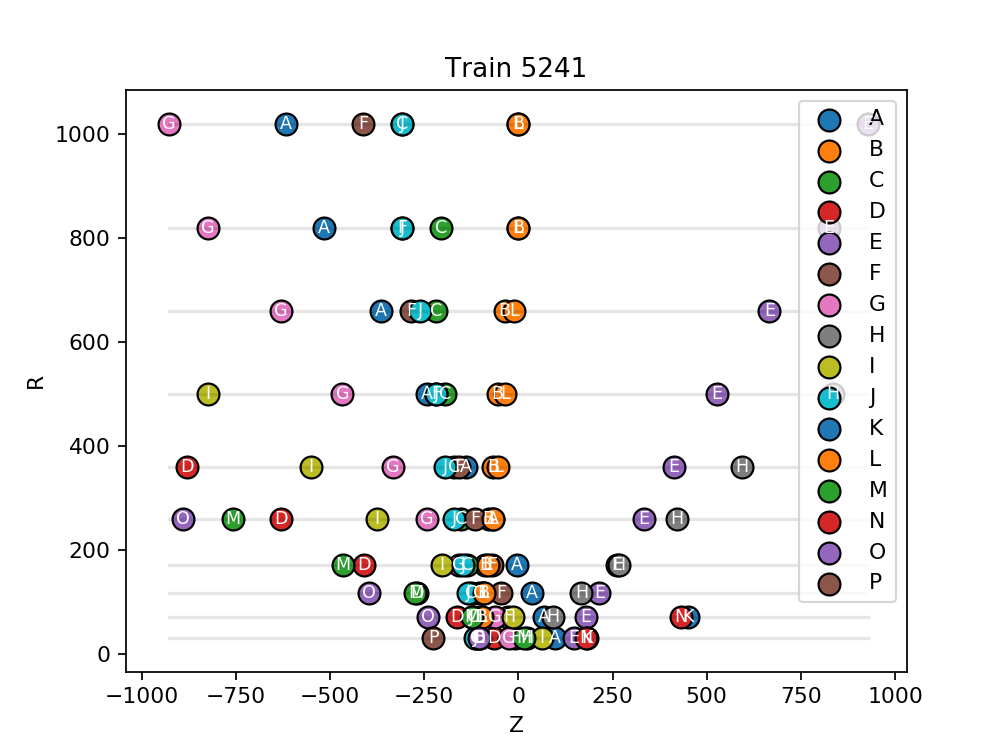

<IPython.core.display.Javascript object>


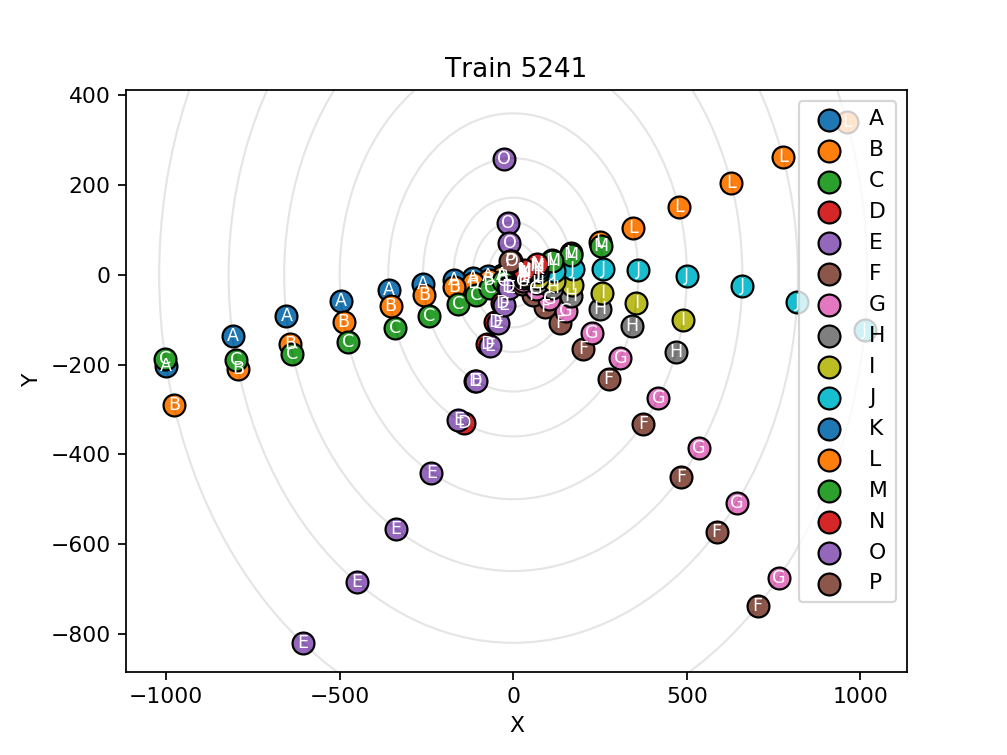

In [7]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [8]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.101575,32.0,97.12500,1,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-3.095430,72.0,68.66560,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-3.088441,117.0,36.94060,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-3.079530,172.0,-3.84940,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-3.065532,260.0,-67.00000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-3.049056,360.0,-139.00000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-3.026410,500.0,-242.00000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-3.000667,660.0,-364.00000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.999025,32.0,-104.07200,,1,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.993077,72.0,-99.51970,,1,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [9]:
input_shape  = (250, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [5]:
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [ ]:
%%time
# 128 + 32
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

### Display information about the model after fitting it.

In [7]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 97.41891855700474%
Percent of tracks assigned correctly: 93.81047268842828%
Percent of events with the correct number of tracks: 95.34461910519951%
CPU times: user 1min 32s, sys: 152 ms, total: 1min 32s
Wall time: 1min 32s


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 100.0%
Percent of tracks assigned correctly: 100.0%


<IPython.core.display.Javascript object>


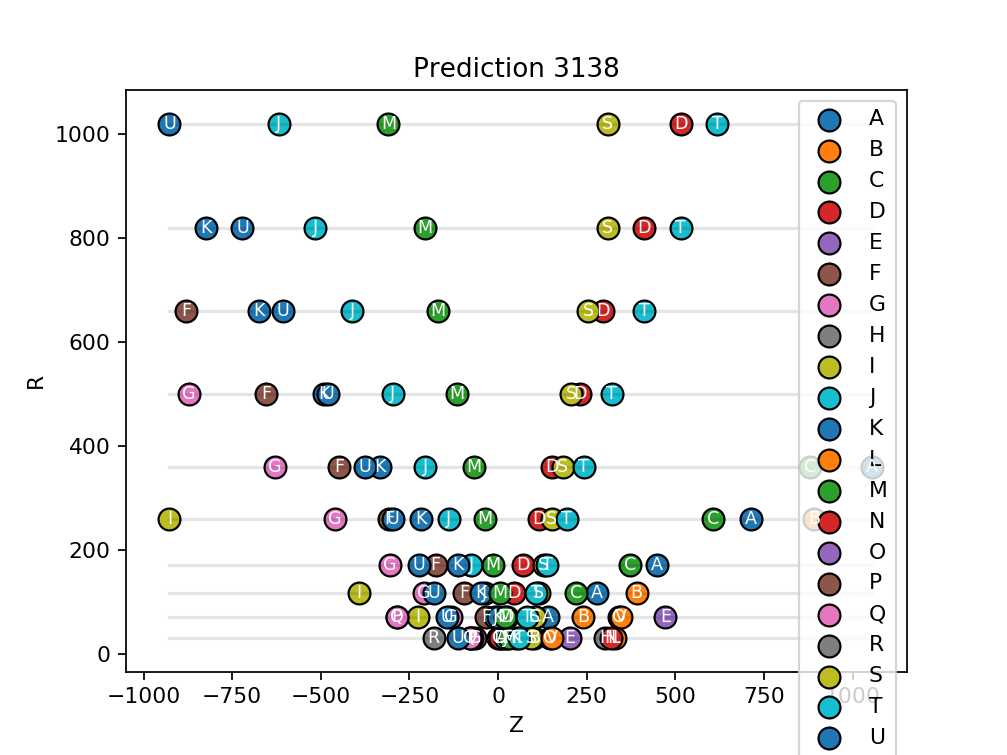

<IPython.core.display.Javascript object>


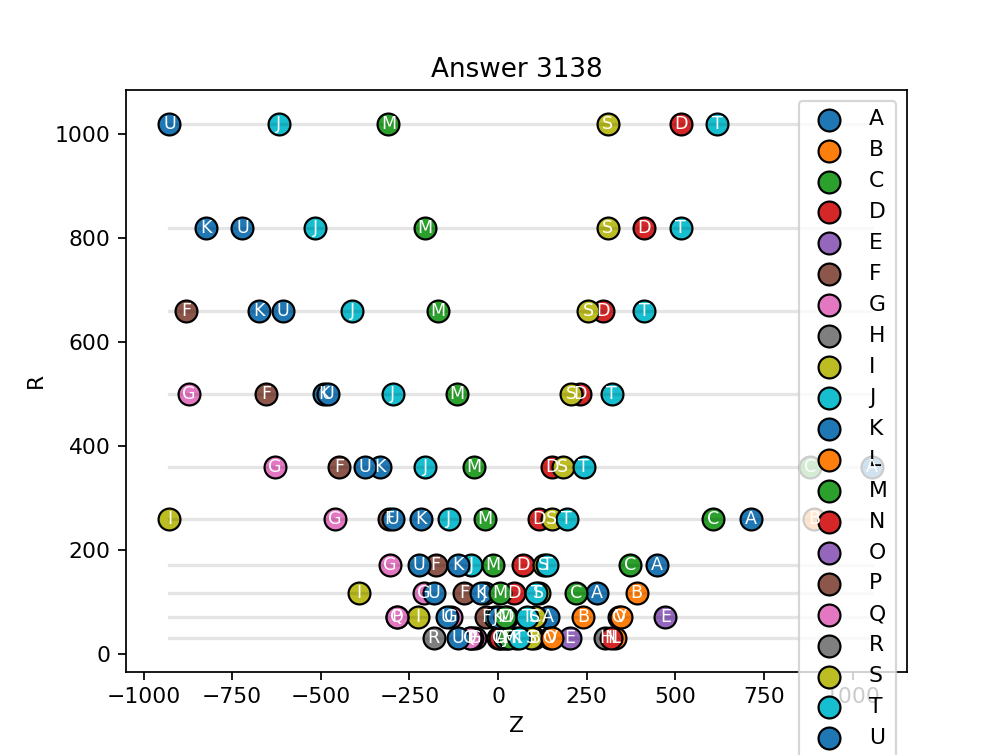

<IPython.core.display.Javascript object>


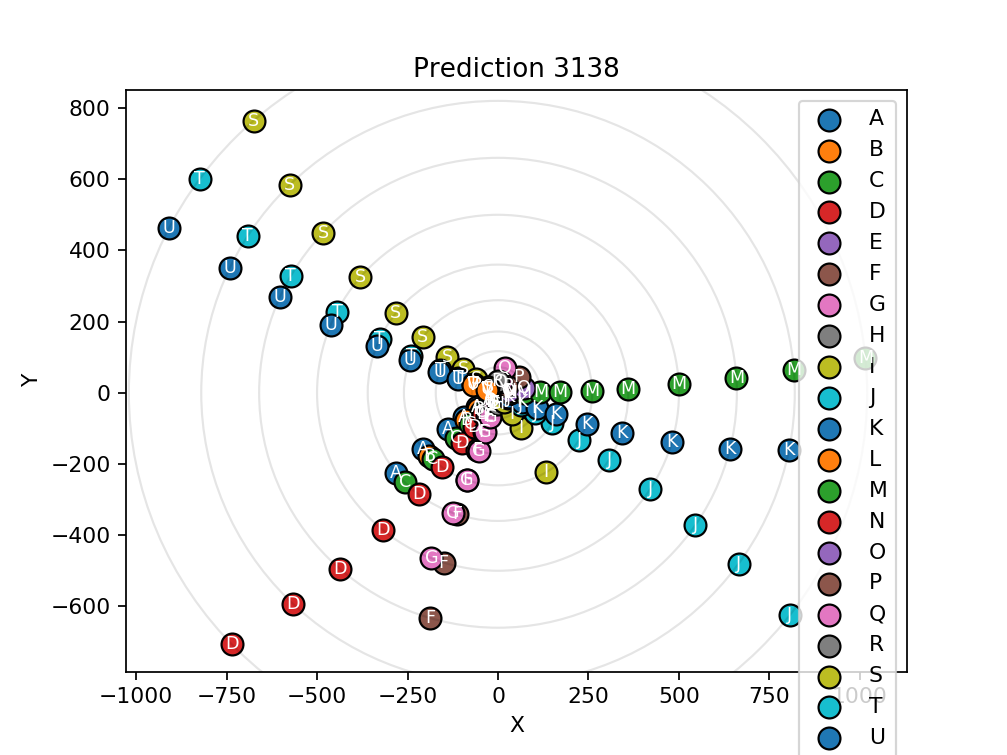

<IPython.core.display.Javascript object>


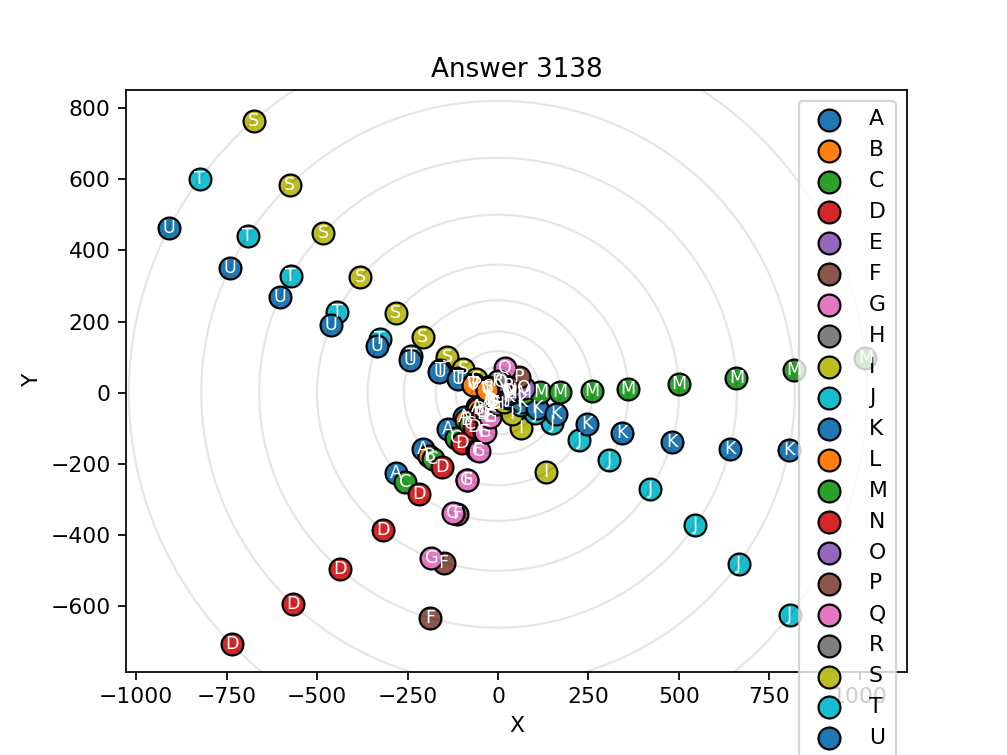

In [12]:
n  = 3138  # np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [13]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.542307,32.0,11.715600,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
1,-2.532706,72.0,139.984000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.522595,117.0,278.538000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.510244,172.0,447.322000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.490699,260.0,714.230000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.465862,360.0,1054.000000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.452455,32.0,101.709000,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.441670,72.0,240.556000,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.430115,117.0,390.934000,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.391645,260.0,891.000000,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>


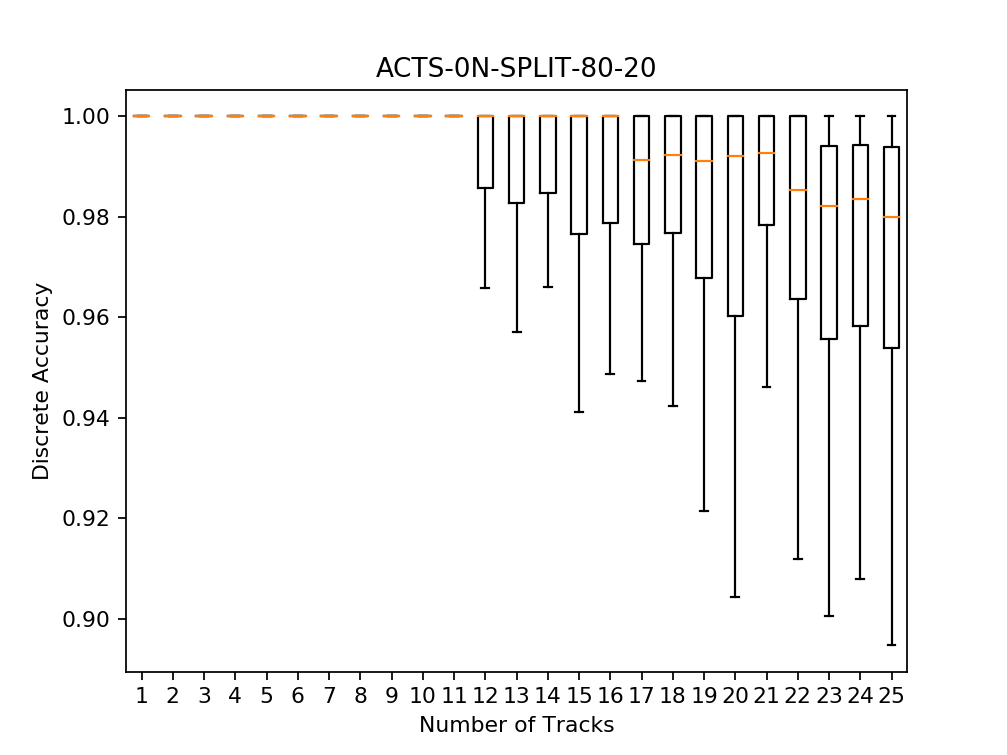

CPU times: user 27.6 s, sys: 4 ms, total: 27.6 s
Wall time: 27.6 s


In [8]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

<IPython.core.display.Javascript object>


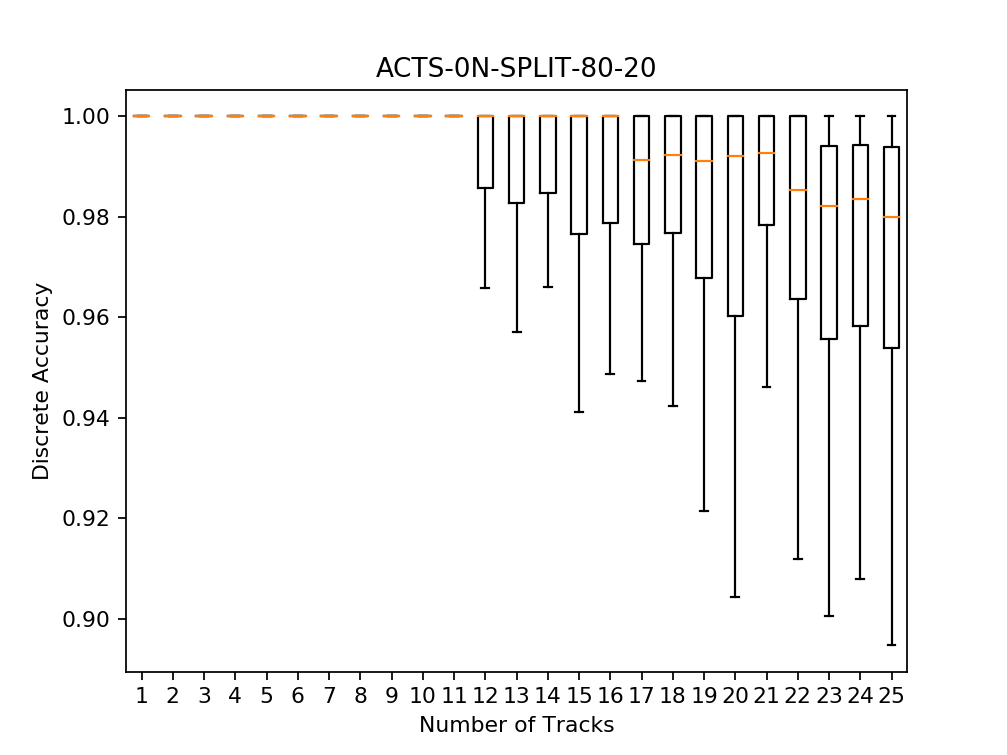

CPU times: user 26.8 s, sys: 28 ms, total: 26.9 s
Wall time: 26.9 s


In [9]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

<IPython.core.display.Javascript object>


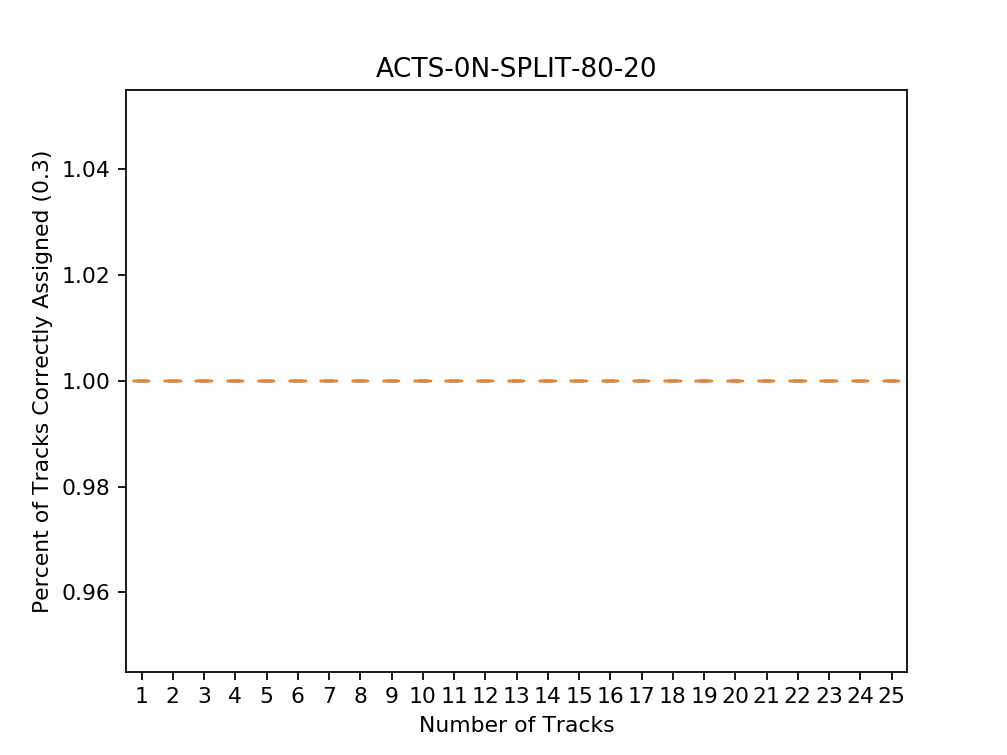

<IPython.core.display.Javascript object>


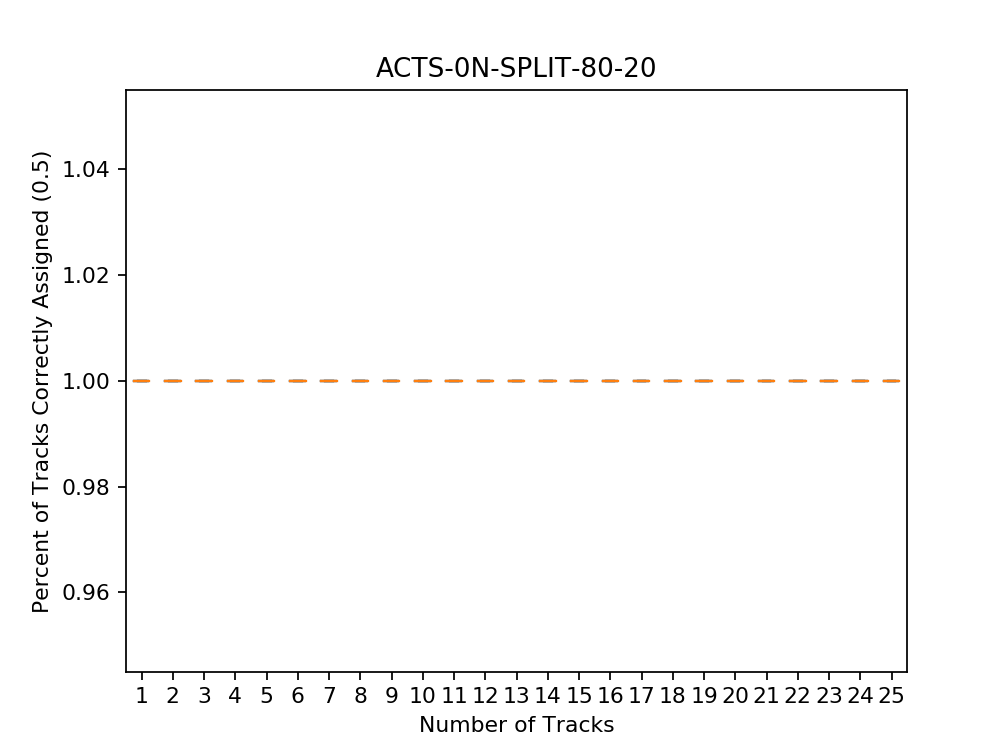

<IPython.core.display.Javascript object>


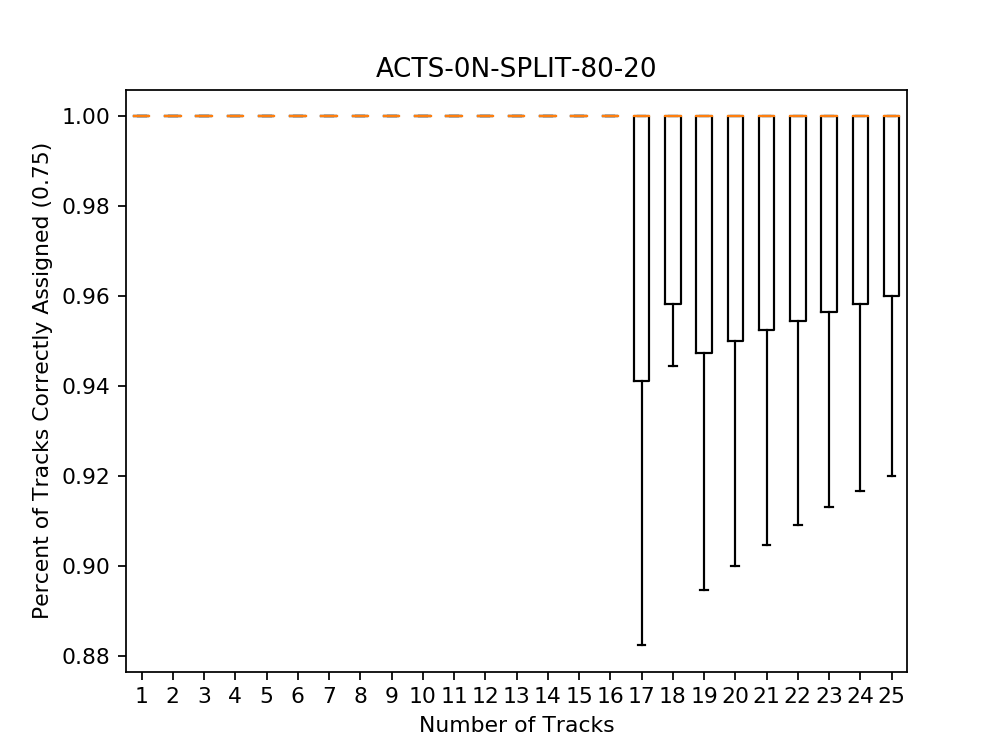

<IPython.core.display.Javascript object>


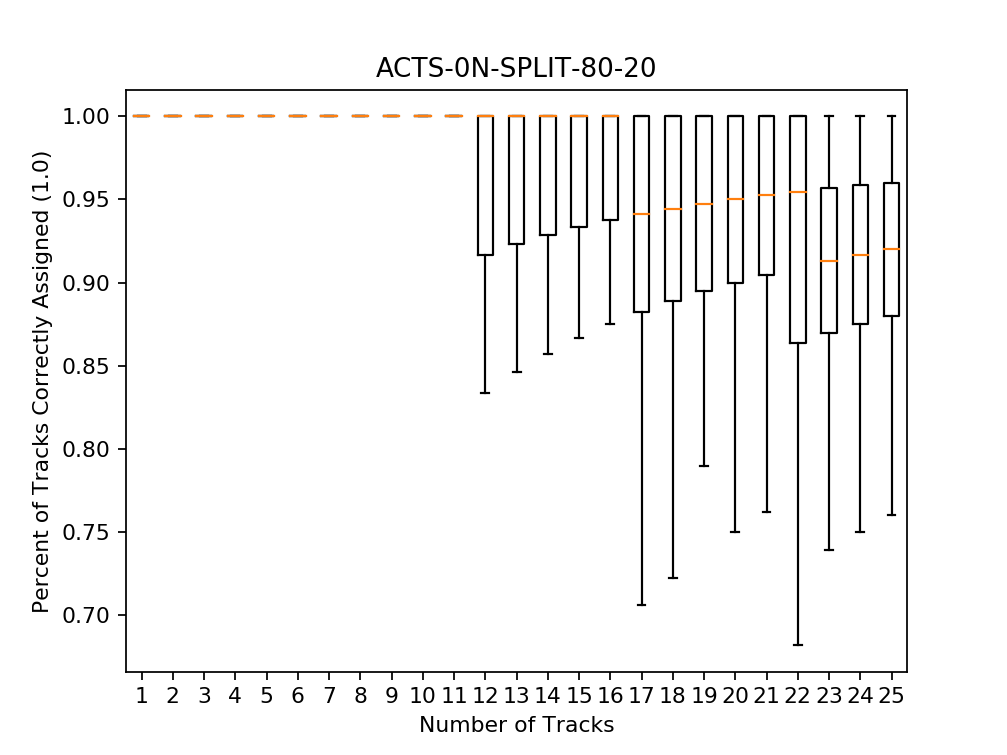

CPU times: user 2min 26s, sys: 32 ms, total: 2min 26s
Wall time: 2min 26s


In [10]:
%%time
for percent in [0.3, 0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

<IPython.core.display.Javascript object>


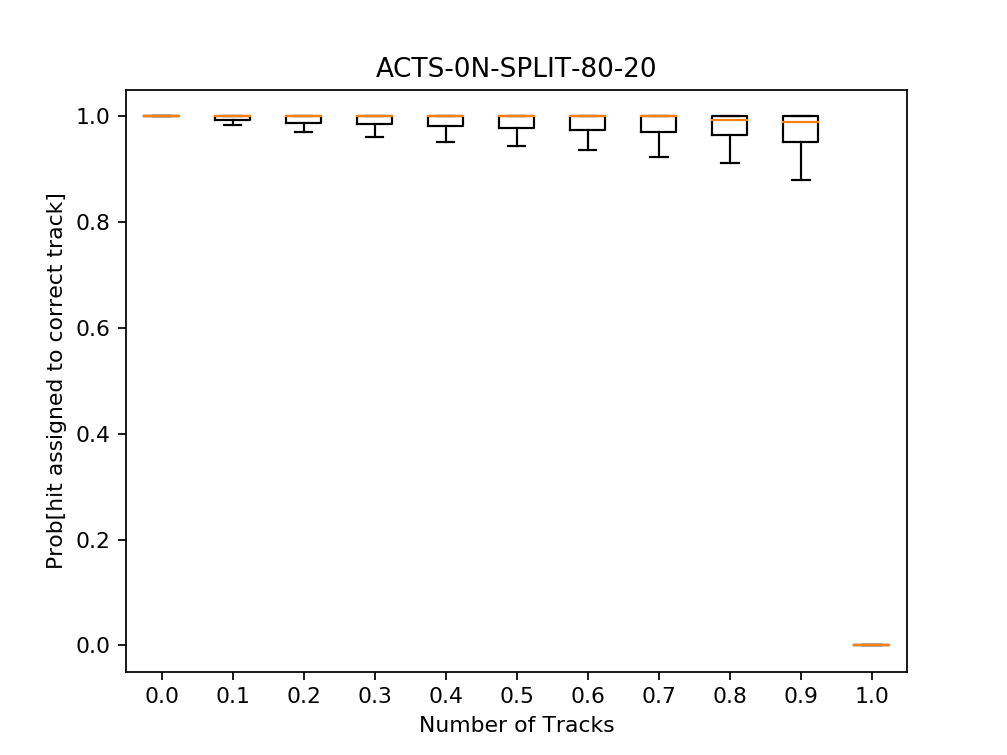

<IPython.core.display.Javascript object>


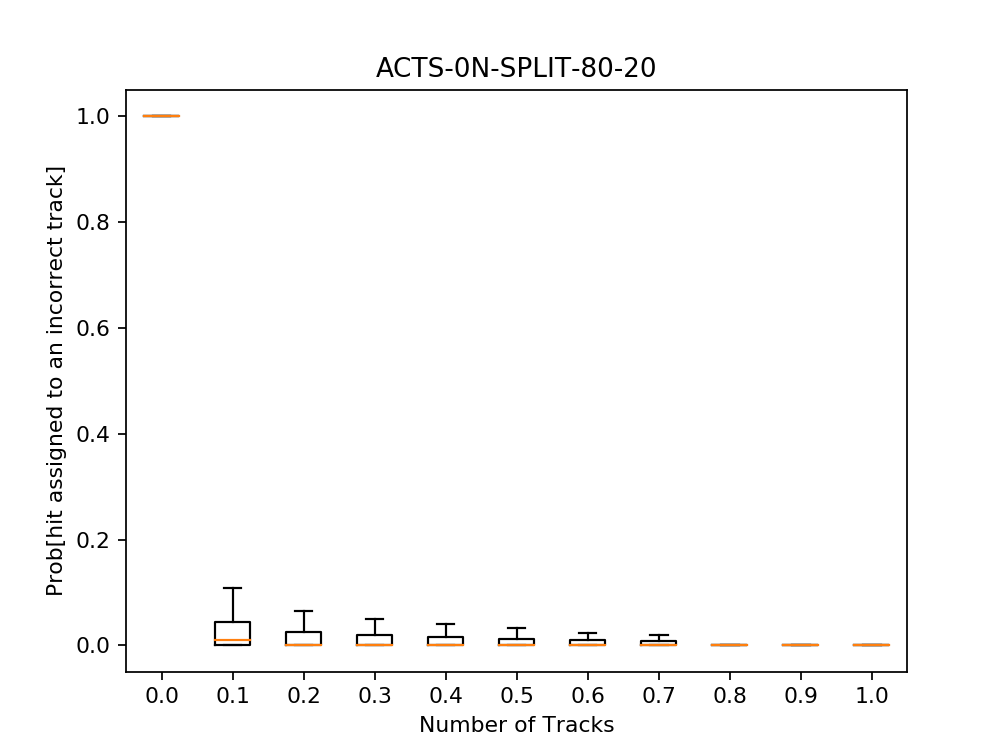

<IPython.core.display.Javascript object>


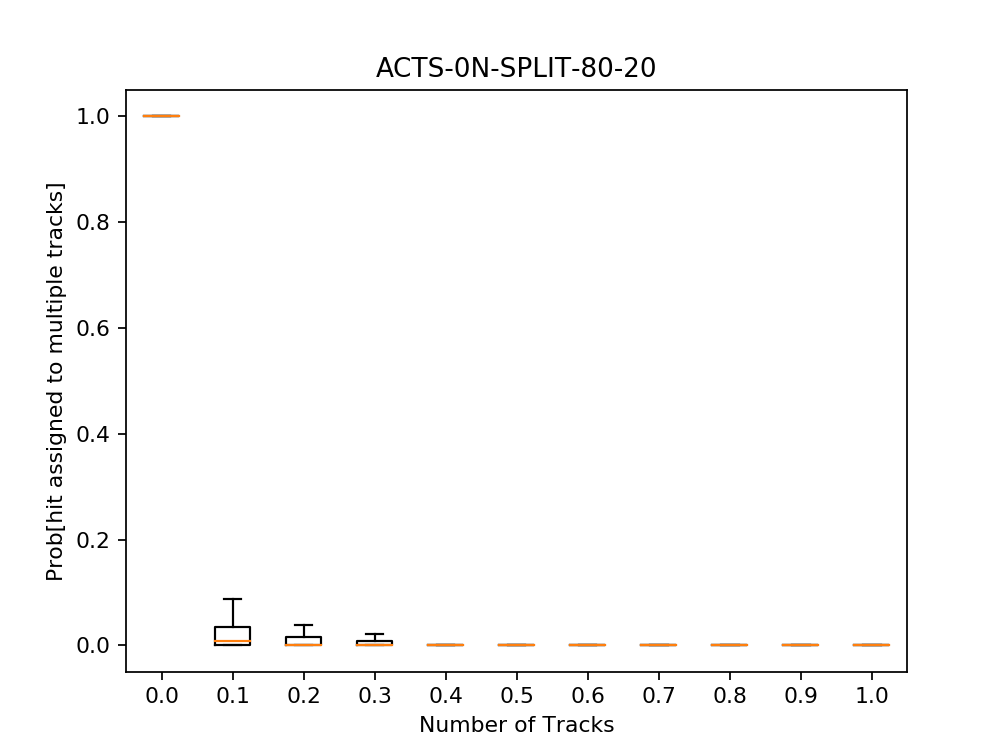

<IPython.core.display.Javascript object>


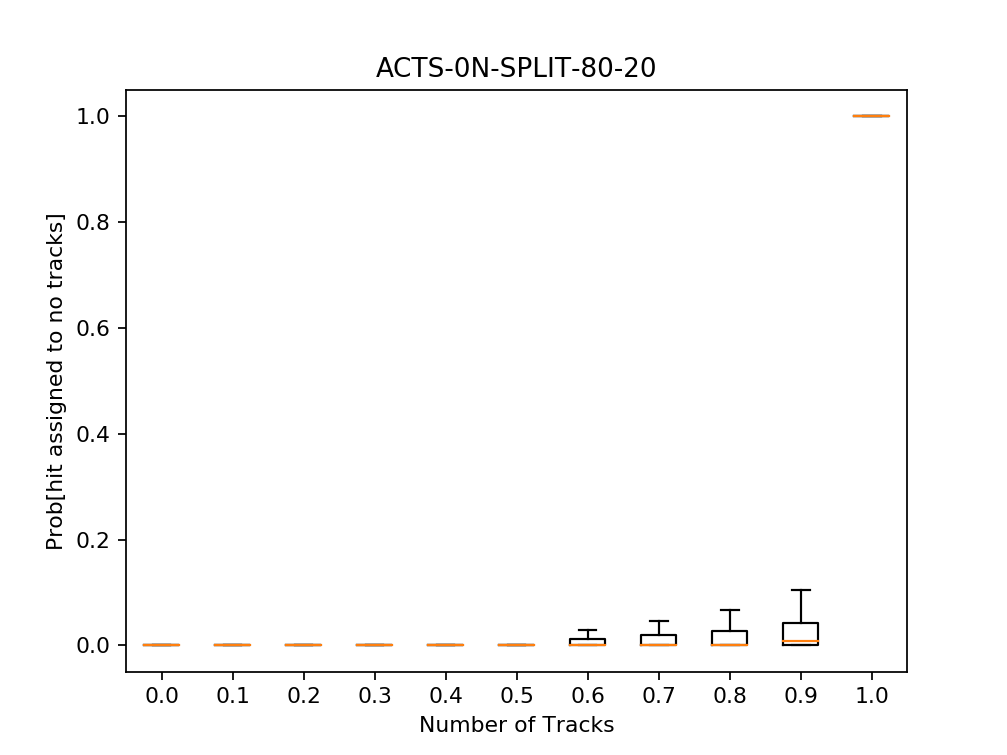

CPU times: user 3min 54s, sys: 60 ms, total: 3min 54s
Wall time: 3min 54s


In [18]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)